In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch_geometric.datasets import ZINC

In [3]:
from graph_to_mol import ZINC_Graph_Add_Mol

In [4]:
%cd /nfs/homedirs/kempern/substructure-gnns

/nfs/homedirs/kempern/substructure-gnns


In [5]:
data = ZINC("datasets/data/ZINC/ZINC_mol", subset = True, pre_transform= ZINC_Graph_Add_Mol())

In [6]:
from torch.utils.data import random_split
a, b = random_split(data, [int(0.2 * len(data)), len(data) - int(0.2 * len(data))])
len(a)

2000

In [7]:
import datasets.fragmentations.fragmentations as frag

In [8]:
from torch_geometric.loader import DataLoader
s = frag.RingsPaths(vocab_size = 15, max_ring = 10, cut_leafs = False)
t = frag.HigherLevelGraph(vocab_size = 16, neighbor = "tree", higher_edge_features=True)
data_pre = t(s(data[0]))
data_pre2 = t(s(data[1]))
dataloader = DataLoader([data_pre, data_pre2],batch_size=2, follow_batch = ["x", "fragments"])

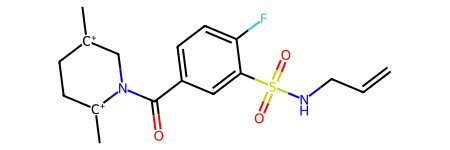

In [9]:
data[80].mol

In [10]:
next(iter(dataloader)).higher_edge_types

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
batch = next(iter(dataloader))
edge_batch = batch.x_batch[batch.edge_index[0]]
edge_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

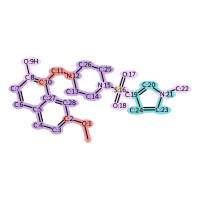

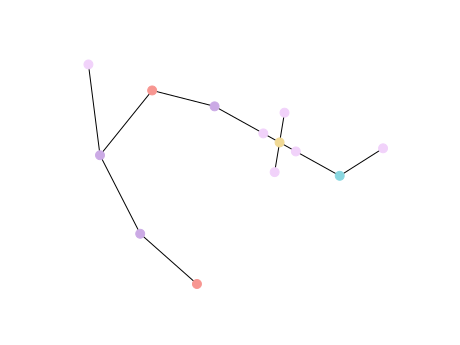

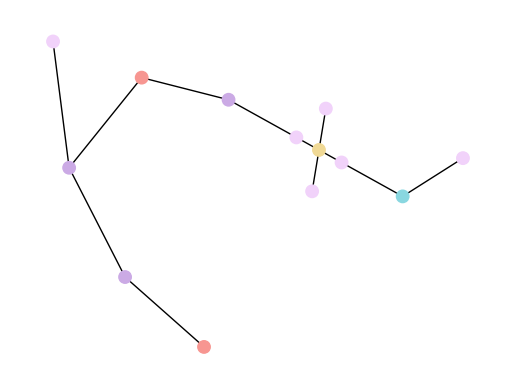

<Figure size 50x50 with 0 Axes>

In [12]:
from IPython.display import SVG
from visualization.visualize_molecules import to_SVG
rings_edges = frag.RingsPaths(vocab_size = 15, max_ring = 10, cut_leafs = False)
higher_level = frag.HigherLevelGraph(vocab_size = 16, neighbor = "tree")
SVG_1, SVG_2  = to_SVG(higher_level(rings_edges(data[0])), higher_level= True, add_idx=True)
display(SVG(SVG_1))
display(SVG(SVG_2))


In [13]:
data_pre.x.size(0)

29

In [14]:
from models.hlg import HLG, HLGAlternative
from models.lightning_models import mae_loss
import torch
torch.autograd.set_detect_anomaly(True)
message_types = {"atom2atom": False, "atom2frag": True, "frag2edge": False, "atom2edge": False, "edge2edge": False, "edge2frag": False, "atom2mol": False, "mol2edge": False, "edge2mol": False, "frag2mol": False, "mol2atom": False, "mol2frag": False, "atomfrag2atom": False, "frag2frag": True}
h = HLGAlternative(data_pre.x.size(1), 10,11, hidden_channels=32, hidden_channels_edge=32, hidden_channels_frag=32, hidden_channels_mol = 8, out_channels=1, num_layers = 3, num_layers_message_before= 0, num_layers_message_after=1, message_types = message_types, attention = False, higher_level_edge_features= "basic", concat = 20, residuals = True, process_after = 2)
batch = next(iter(dataloader))
xhat = h(batch)
loss = mae_loss(xhat, batch, "train")
loss.backward()

/nfs/homedirs/kempern/anaconda3/envs/substructureML2/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/nfs/homedirs/kempern/anaconda3/envs/substructureML2/lib/python3.8/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [15]:
from models.gcn import CliqueEncoder, HimpNet, HimpNetAlternative

h = HimpNet(data_pre.x.size(0), 11, 10,10,1, 3, 0,linear_atom_encoder= False,encoding_size_scaling= True, rbf = 10, degree_scaling = False, inter_message_passing = False, higher_message_passing =False, low_high_edges = False, fragment_specific= False, reduction = "mean", concat = False, graph_rep = False, graph_rep_node = False, learned_edge_rep=True, higher_level_edge_features=True)
batch = next(iter(dataloader))
xhat = h(batch)
loss = mae_loss(xhat, batch, "train")
loss.backward()

In [25]:
from models.gcn import CliqueEncoder, HimpNet, HimpNetAlternative, HimpNetSmall
h = HimpNetSmall(data_pre.x.size(0),4,4,120, 1, 3,0,False, True, 0, higher_message_passing=True, learned_edge_rep=True, atom_feature_params = {"num_atom_types": 30, "num_atom_features" :1}, edge_feature_params= {"num_bond_types": 4, "num_bond_features":1})
#c = CliqueEncoder(11, 4, encoding_size_scaling=False)
h(next(iter(dataloader)))
#h(data_pre)

tensor([[-0.1303],
        [-0.1294]], grad_fn=<AddmmBackward0>)

In [27]:
h

HimpNetSmall(
  (atom_encoder): AtomEncoder(
    (embeddings): ModuleList(
      (0): Embedding(30, 120)
    )
  )
  (clique_encoder): CliqueEncoder(
    (embedding): Embedding(4, 120)
  )
  (bond_encoder): BondEncoder(
    (embeddings): ModuleList(
      (0): Embedding(4, 120)
    )
  )
  (atom2bond): ModuleList(
    (0): InterMessage(
      (transform): Sequential(
        (0): Linear(in_features=120, out_features=120, bias=True)
        (1): ReLU()
      )
    )
    (1): InterMessage(
      (transform): Sequential(
        (0): Linear(in_features=120, out_features=120, bias=True)
        (1): ReLU()
      )
    )
    (2): InterMessage(
      (transform): Sequential(
        (0): Linear(in_features=120, out_features=120, bias=True)
        (1): ReLU()
      )
    )
  )
  (bond_batch_norms): ModuleList(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [26]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(h)

+----------------------------------+------------+
|             Modules              | Parameters |
+----------------------------------+------------+
| atom_encoder.embeddings.0.weight |    3600    |
| clique_encoder.embedding.weight  |    480     |
| bond_encoder.embeddings.0.weight |    480     |
|  atom2bond.0.transform.0.weight  |   14400    |
|   atom2bond.0.transform.0.bias   |    120     |
|  atom2bond.1.transform.0.weight  |   14400    |
|   atom2bond.1.transform.0.bias   |    120     |
|  atom2bond.2.transform.0.weight  |   14400    |
|   atom2bond.2.transform.0.bias   |    120     |
|    bond_batch_norms.0.weight     |    120     |
|     bond_batch_norms.0.bias      |    120     |
|    bond_batch_norms.1.weight     |    120     |
|     bond_batch_norms.1.bias      |    120     |
|    bond_batch_norms.2.weight     |    120     |
|     bond_batch_norms.2.bias      |    120     |
|       bond_convs.0.weight        |   14400    |
|        bond_convs.0.bias         |    120     |


494647

In [4]:
from datasets.data import load_fragmentation
d = load_fragmentation("ZINC", False, False, False, False, fragmentation_method = ["RingsPaths", "higher_level_graph_tree", {"vocab_size": 30, "max_ring": 15}], loader_params={"batch_size": 128, "num_workers": 2}, encoding = [{"name":"random-walk", "walk_length": 7}])

Extracting /tmp/ZINC/ZINC_-6717772075685411597/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:04<00:00, 226.87it/s]
Done!


In [9]:
next(iter(d[0]))

FragmentDataBatch(x=[2889, 1], x_batch=[2889], x_ptr=[129], edge_index=[2, 6180], edge_attr=[6180], y=[128], mol=[128], substructures=[128], fragment_types=[1462, 2], fragments=[1462, 30], fragments_batch=[1462], fragments_ptr=[129], fragments_edge_index=[2, 4282], low_high_edge_index=[2, 6300], higher_edge_index=[2, 2688], random_walk_pe=[2889, 7], batch=[2889], ptr=[129])

In [11]:
from models.gcn import CliqueEncoder, HimpNet
h = HimpNet(1, 11, 10,10,1, 3, 0,linear_atom_encoder= False,encoding_size_scaling= True, degree_scaling = False, inter_message_passing = True, higher_message_passing =True, low_high_edges = False, fragment_specific= True, reduction = "mean", concat = False, additional_atom_features = [("random_walk_pe",7)])
#c = CliqueEncoder(11, 4, encoding_size_scaling=False)
h(next(iter(d[0])))

tensor([[ 0.1290],
        [ 0.1518],
        [ 0.0963],
        [ 0.1720],
        [ 0.1145],
        [ 0.0919],
        [ 0.0746],
        [ 0.0526],
        [ 0.1042],
        [ 0.0888],
        [ 0.0414],
        [ 0.0067],
        [ 0.0239],
        [ 0.2410],
        [ 0.0147],
        [ 0.1615],
        [ 0.1638],
        [ 0.1164],
        [ 0.0566],
        [ 0.0895],
        [ 0.0942],
        [ 0.0273],
        [ 0.1094],
        [ 0.1518],
        [ 0.1618],
        [ 0.0477],
        [ 0.0360],
        [ 0.1143],
        [ 0.1350],
        [ 0.1486],
        [ 0.1153],
        [ 0.0691],
        [-0.0009],
        [ 0.2047],
        [-0.0433],
        [ 0.1526],
        [ 0.1835],
        [ 0.0236],
        [ 0.2161],
        [ 0.0908],
        [ 0.0956],
        [ 0.1096],
        [ 0.0884],
        [ 0.1283],
        [ 0.0764],
        [ 0.0669],
        [ 0.1444],
        [ 0.0812],
        [ 0.0958],
        [ 0.0757],
        [ 0.2050],
        [ 0.1037],
        [ 0.

In [7]:
from tqdm import tqdm
vocab_constructor = frag.MagnetVocab(max_vocab_size = 100)
for d in tqdm(data):
    vocab_constructor(d)
vocab = vocab_constructor.get_vocab()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [09:36<00:00, 17.35it/s]


In [19]:
vocab_constructor_brics = frag.BRICSVocab(max_vocab_size = 100)
for d in data:
    vocab_constructor_brics(d)
vocab_brics = vocab_constructor_brics.get_vocab()

In [20]:
vocab_constructor_psm = frag.PrincipalSubgraphVocab(max_vocab_size=100, vocab_path= "/tmp/psm_vocab")
for d in data:
    vocab_constructor_psm(d)
vocab_psm = vocab_constructor_psm.get_vocab()

100%|██████████| 10000/10000 [00:07<00:00, 1323.67it/s]


INFO::Added 10 atoms, 90 principal subgraphs to extract


100%|██████████| 90/90 [08:16<00:00,  5.52s/it]

INFO::sorting vocab by atom num


In [8]:
magnet = frag.Magnet(vocab)
substructures = frag.FragmentRepresentation(vocab_size=100)
substructures(magnet(data[0])).fragments_edge_index

tensor([[ 0,  1,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 10, 11, 12, 12, 13, 14,
         15, 15, 16, 17, 18, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
        [ 0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  1,  3,  3,  3,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  6,  6,  6,  2,  6,  6,  4,  4,  1,  1]])

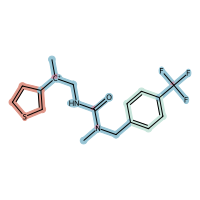

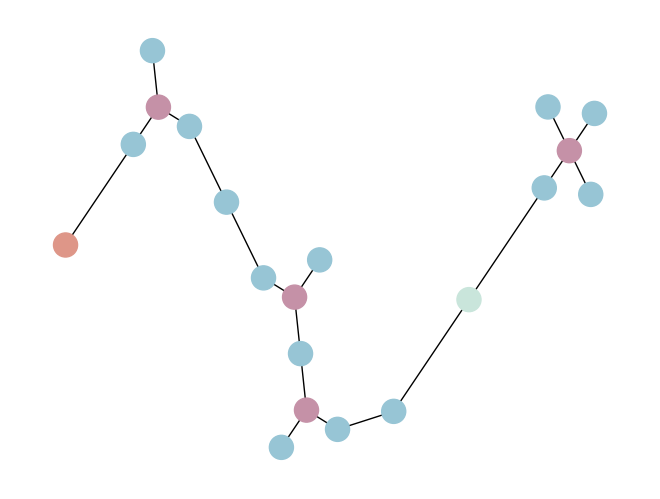

In [50]:
from IPython.display import SVG
from visualization.visualize_molecules import to_SVG
rings_edges = frag.RingsEdges(max_ring= 15)
higher_level = frag.HigherLevelGraph(vocab_size = 40, neighbor = "tree")
SVG(to_SVG(higher_level(rings_edges(data[40])), higher_level= True))

In [37]:
graph

FragmentData(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1], mol=<rdkit.Chem.rdchem.RWMol object at 0x7fad09519130>, substructures=[29], fragments=[13, 41], fragments_edge_index=[2, 42], higher_edge_index=[2, 24])

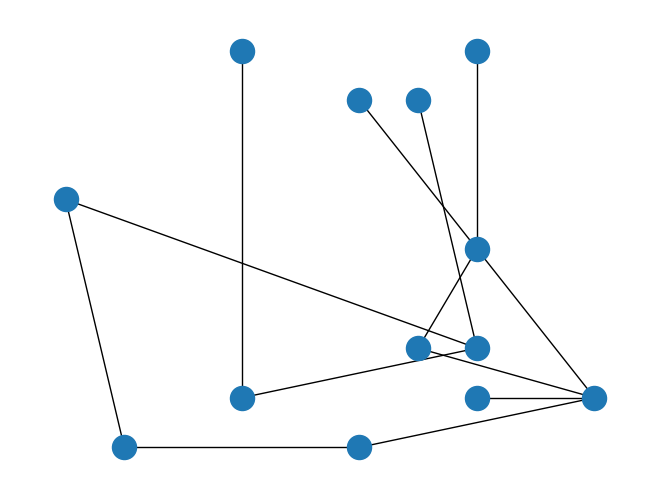

In [36]:
import networkx as nx
import numpy as np
rings_paths = frag.RingsPathsJunctions()
higher_level = frag.HigherLevelGraph(vocab_size = 40, neighbor = "tree")
graph = higher_level(rings_paths(data[0]))
g = nx.Graph()
g.add_nodes_from(range(graph.fragments.size(0)))
g.add_edges_from([(int(edge[0]), int(edge[1])) for edge in graph.higher_edge_index.T])
pos = [(np.random.randint(0, 10), np.random.randint(0, 10)) for i in range(g.number_of_nodes())]
nx.draw(g, pos)

In [31]:
g.edges

EdgeView([(tensor(0), tensor(4)), (tensor(4), tensor(0)), (tensor(0), tensor(1)), (tensor(1), tensor(0)), (tensor(1), tensor(5)), (tensor(5), tensor(1)), (tensor(1), tensor(6)), (tensor(6), tensor(1)), (tensor(2), tensor(6)), (tensor(6), tensor(2)), (tensor(2), tensor(7)), (tensor(7), tensor(2)), (tensor(7), tensor(12)), (tensor(12), tensor(7)), (tensor(8), tensor(12)), (tensor(12), tensor(8)), (tensor(9), tensor(12)), (tensor(12), tensor(9)), (tensor(10), tensor(12)), (tensor(12), tensor(10)), (tensor(3), tensor(10)), (tensor(10), tensor(3)), (tensor(3), tensor(11)), (tensor(11), tensor(3))])

In [29]:
graph.higher_edge_index.T

tensor([[ 0,  4],
        [ 4,  0],
        [ 0,  1],
        [ 1,  0],
        [ 1,  5],
        [ 5,  1],
        [ 1,  6],
        [ 6,  1],
        [ 2,  6],
        [ 6,  2],
        [ 2,  7],
        [ 7,  2],
        [ 7, 12],
        [12,  7],
        [ 8, 12],
        [12,  8],
        [ 9, 12],
        [12,  9],
        [10, 12],
        [12, 10],
        [ 3, 10],
        [10,  3],
        [ 3, 11],
        [11,  3]])

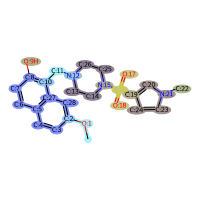

In [32]:
from IPython.display import SVG
from visualization.visualize_molecules import to_SVG
SVG(to_SVG(magnet(data[0]), add_idx=True))

In [ ]:
magnet

In [26]:
psm = frag.PSM(vocab)



TypeError: expected str, bytes or os.PathLike object, not list

In [35]:
frags = frag.FragmentRepresentation(20)

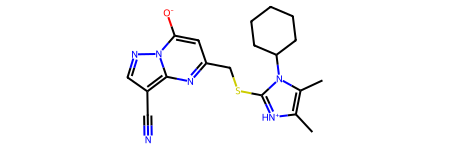

In [19]:
mol = data[3].mol
mol

In [46]:
frags(psm(data[0]))

FragmentData(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1], mol=<rdkit.Chem.rdchem.RWMol object at 0x7f422f0dd8b0>, substructures=[29], fragments=[14, 20], fragments_edge_index=[2, 29])

In [47]:
from torch_geometric.loader import DataLoader
loader = DataLoader([frags(psm(data[i])) for i in range(2)], batch_size=2, follow_batch = ["x", "fragments"])
batch = next(iter(loader))
batch

FragmentDataBatch(x=[55, 1], x_batch=[55], x_ptr=[3], edge_index=[2, 120], edge_attr=[120], y=[2], mol=[2], substructures=[2], fragments=[25, 20], fragments_batch=[25], fragments_ptr=[3], fragments_edge_index=[2, 55], batch=[55], ptr=[3])

In [45]:
batch.num_nodes

55

In [12]:
psm(data[3]).substructures

[[(0, 12)],
 [(9, 5)],
 [(9, 5)],
 [(1, 12)],
 [(15, 8)],
 [(12, 6)],
 [(12, 6)],
 [(13, 6)],
 [(13, 6)],
 [(14, 6)],
 [(14, 6)],
 [(15, 8)],
 [(2, 19)],
 [(3, 12)],
 [(11, 5)],
 [(4, 16)],
 [(10, 5)],
 [(10, 5)],
 [(5, 12)],
 [(6, 16)],
 [(16, 8)],
 [(16, 8)],
 [(17, 8)],
 [(17, 8)],
 [(7, 17)],
 [(11, 5)],
 [(8, 16)]]

In [23]:
psm(data[5]).substructures

[[(0, 12)],
 [(1, 12)],
 [(15, 3)],
 [(15, 3)],
 [(15, 3)],
 [(2, 16)],
 [(3, 16)],
 [(12, 1)],
 [(12, 1)],
 [(12, 1)],
 [(12, 1)],
 [(4, 16)],
 [(11, 5)],
 [(11, 5)],
 [(14, 8)],
 [(14, 8)],
 [(5, 16)],
 [(6, 16)],
 [(13, 0)],
 [(13, 0)],
 [(13, 0)],
 [(13, 0)],
 [(13, 0)],
 [(13, 0)],
 [(7, 12)],
 [(8, 14)],
 [(9, 14)],
 [(10, 14)]]

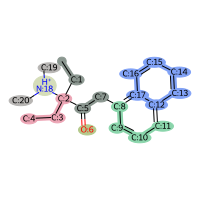

In [29]:
from IPython.display import SVG
from visualization.visualize_molecules import to_SVG
SVG(to_SVG(psm(data[4]), add_idx=True))

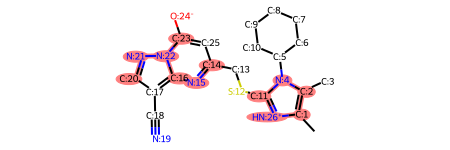

In [17]:
data[3].mol